In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression

# set Figure size for seaborn plots
sns.set(rc={'figure.figsize':(11,8)})

# Project: Writing a Data Science Blog Post

**Motivation:** I thought it may a interisting outcome to share in my company, given the fact that I can predict their job satisfaction based on the tools and languages they are all using.

**Acknowledgement:** Data used for this project is available on stackoverflow using the following link: https://insights.stackoverflow.com/survey/

No third party code from other students of udacity was used while creating this project. Images are created by my own.

## Section 1: Business Understanding

### Brief description

Can you be more happy in a different programming language? In this blog post I will try to provide that this is acually true, given the data of the stackoverflow survey of 2020.

#### Question 1:
**What is the general job satisfaction, more positive or more negative?**

#### Qurstion 2:
**Is the job satisfaction correlated with some programming language, framework or platform?**

#### Question 3:
**Are we able to predict a job satisfaction based on this data?**

## Section 2: Data Understanding

### Collect initial data

The data is available from following url: https://insights.stackoverflow.com/survey/

### Describe data

In [2]:
# set data path
data = os.path.join("developer_survey_2020", "survey_results_public.csv")

In [3]:
# read csv using pandas
df = pd.read_csv(data)

The data is saved in csv format.

In [4]:
# total size
len(df)

64461

The Dataset contains of 64461 responses for the survey

In [5]:
# we only care about data with job satisfaction, other rows are filtered out
len(df[~ df['JobSat'].isnull()])

45194

45194 responses reference to a particular job satisfaction, resulting in 19267 missing responses for a job satisfaction.

In [6]:
list(df.columns)

['Respondent',
 'MainBranch',
 'Hobbyist',
 'Age',
 'Age1stCode',
 'CompFreq',
 'CompTotal',
 'ConvertedComp',
 'Country',
 'CurrencyDesc',
 'CurrencySymbol',
 'DatabaseDesireNextYear',
 'DatabaseWorkedWith',
 'DevType',
 'EdLevel',
 'Employment',
 'Ethnicity',
 'Gender',
 'JobFactors',
 'JobSat',
 'JobSeek',
 'LanguageDesireNextYear',
 'LanguageWorkedWith',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'NEWCollabToolsDesireNextYear',
 'NEWCollabToolsWorkedWith',
 'NEWDevOps',
 'NEWDevOpsImpt',
 'NEWEdImpt',
 'NEWJobHunt',
 'NEWJobHuntResearch',
 'NEWLearn',
 'NEWOffTopic',
 'NEWOnboardGood',
 'NEWOtherComms',
 'NEWOvertime',
 'NEWPurchaseResearch',
 'NEWPurpleLink',
 'NEWSOSites',
 'NEWStuck',
 'OpSys',
 'OrgSize',
 'PlatformDesireNextYear',
 'PlatformWorkedWith',
 'PurchaseWhat',
 'Sexuality',
 'SOAccount',
 'SOComm',
 'SOPartFreq',
 'SOVisitFreq',
 'SurveyEase',
 'SurveyLength',
 'Trans',
 'UndergradMajor',
 'WebframeDesireNextYear',
 'WebframeWorkedWith',
 'WelcomeChange',
 'W

61 columns are present in the data where `JobSat` is the most interisting column for us in this analysis.

In [7]:
list(df.dtypes)

[dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('O')]

Most of the column contain strings, some float and only 1 contains int values.

In [8]:
set(df['JobSat'])

{'Neither satisfied nor dissatisfied',
 'Slightly dissatisfied',
 'Slightly satisfied',
 'Very dissatisfied',
 'Very satisfied',
 nan}

The Job satisfaction can have 5 different values. From the description of, we can assume that the values have an order: 
* Very dissatisfied (negative) 
* Slightly dissatisfied ( light negative)
* Neither satisfied nor dissatisfied (neutral)
* Slightly satisfied (light positive)
* Very satisfied (postive)

## Section 3: Data Preparation
### Select Data

In [9]:
df = df[~ df['JobSat'].isnull()]

we are only interisted in all responses of the survey with any value in `JobSat` - this is our basement for any further analysis.

### Clean data

removing all values from `JobSat` containing **null** as value, cleaned our data already

### Construct data

We will be using this function to generate new columns out of the existing ones, in order to enable a training on it.

In [10]:
def to_list(elements) -> list:
    '''
    Return a list of elements that where separated by ";"

    :param elements: the (potencial) elements to convert to a list, can be (str) or (np.nan)
    :returns: (list[str]) list of elements with 0 or more elements
    
    Example:
    >>> import numpy as np; to_list(np.nan)
    []
    
    >>> to_list("c++;c#")
    ["c++", "c#"]
    '''

    if type(elements) != str: # assuming nan
        return []
    else:
        return elements.split(";")

In [11]:
def df_to_features(df: pd.DataFrame, column: str) -> list:
    '''
    Explode a column of a pd.DataFrame containing several features
    
    :param df: (pd.DataFrame) DataFrame that have the column to explode
    :param column: (str) The name of the column with the values to explode
    
    :returns: (list[dict]) A list of dicts that have a true value for a particular line
    
    Example:
    >>> df_to_features(pd.DataFrame([{'a': 'b;c'}]), 'a')
    [{'b': 1, 'c': 1}]
    '''
    
    records = []
    for index, row in df.iterrows():
        line = {}
        elements = to_list(row[column])
        if len(elements)>0:
            for e in elements:
                line[e] = 1
                    
        records.append(line)
        
    return records

In [12]:
def df_extract_features(df: pd.DataFrame, column: str) -> pd.DataFrame:
    '''
    Extract features of a particular column and returns the filled pd.DataFrame back
    
    :param df: (pd.DataFrame) The DataFrame with the data to be extracted
    :param column: (str) The column with the data to extract
    :returns: pd.DataFrame with feature columns, filled missing values with 0 
    
    Example:
    >>> df_extract_features(pd.DataFrame([{'a': 'b;c'}, {'a': 'c'}]), 'a')
    pd.DataFrame([{'b': 1.0, 'c': 1}, {'b': 0.0, 'c': 1}])
    '''
    return pd.DataFrame(df_to_features(df, column)).fillna(0.)

In [13]:
job_satisfaction_df = df_extract_features(df, 'JobSat')

In [14]:
job_satisfaction_df.head()

,Slightly satisfied,Very dissatisfied,Slightly dissatisfied,Very satisfied,Neither satisfied nor dissatisfied
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0


We have created a dataframe that converted the string value from the column `JobSat` into 5 columns, where only one column have a **1** and all other have a **0**. 

In [15]:
platform_features_df = df_extract_features(df, 'PlatformWorkedWith')
platform_features_df.head()

,Windows,iOS,Android,Docker,WordPress,Linux,Raspberry Pi,AWS,Heroku,MacOS,Google Cloud Platform,Kubernetes,Arduino,Slack Apps and Integrations,Microsoft Azure,IBM Cloud or Watson
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We extracted the relevant data for the source column `PlatformWorkedWith`. In contrast to `JobSat`, several columns can have a value of **1**.

In [16]:
misc_tech_features_df = df_extract_features(df, 'MiscTechWorkedWith')
misc_tech_features_df.head()

,.NET,.NET Core,React Native,Ansible,Pandas,Node.js,TensorFlow,Torch/PyTorch,Unity 3D,Teraform,Hadoop,Flutter,Cordova,Keras,Xamarin,Unreal Engine,Apache Spark,Puppet,Chef
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We extracted the relevant data from the source column ``MiscTechWorkedWith``. The Range here is very broad - from particular python frameworks like **pandas** and **keras**, to game development frameworks like **Unity 3D** to provisioning tools like **ansible**, **puppet** and **chef**.  

In [17]:
language_features_df = df_extract_features(df, 'LanguageWorkedWith')
language_features_df.head()

,C#,HTML/CSS,JavaScript,Swift,Java,PHP,Python,SQL,C,TypeScript,...,C++,Go,Haskell,Ruby,Rust,Dart,Scala,Assembly,Objective-C,Julia
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
len(language_features_df.columns)

25

And finally here we have all Programming languages that where part of the survey and got converted into a binary feature dataframe. This is the only dataset that gets dotted out as their are 25 total columns- not fitting on the screen.

## Section 4: Data Modeling
### Binary Classification

We will be using two different approaches to predict the job salutation. The first approach is to use see this problem as a binary classification problem, using the values from our (new) created column ``Very satisfied`` as label.

In [19]:
def df_to_binary_labels(df):
    '''
    Convert a dataframe with the column "Very satisfied" to a binary form.
    
    :param df: (pd.DataFrame) The DataFrame that have the data to be converted to binary labels
    :returns: (list[int]) 0/1 represantation of the column
    
    Example:
    >>> df_to_binary_labels(pd.DataFrame([{'Very satisfied': 1}, {'Very satisfied': 0}]))
    [{'label': 1}, {'label': 0}]
    '''

    records = []
    for index, row in df.iterrows():
        records.append({"label": row['Very satisfied']})
        
    return records

In [20]:
binary_y = pd.DataFrame(df_to_binary_labels(job_satisfaction_df))

In [21]:
X = pd.concat([platform_features_df, misc_tech_features_df, language_features_df], axis=1, join='inner')

We combine every constructed dataframe together, and use it as our input Matrix **X**

In [22]:
len(binary_y[binary_y['label'] == 1])

14611

In [23]:
len(binary_y[binary_y['label'] == 0])

30583

We have 14611 positive examples and 30583 negative examples.

In [24]:
def fit_classifier(X: pd.DataFrame, y: pd.DataFrame) -> dict:
    '''
    Train a DecisionTree Model for a binary classification
    
    :param X: (pd.DataFrame) The DataFrame with the features
    :param y: (pd.DataFrame) The DataFrame with the label
    :returns: (dict) r2_score and confusion (matrix)
    '''

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    classifier = DecisionTreeClassifier()
    classifier.fit(X_train, y_train)
    y_pred_test = classifier.predict(X_test)
    r2_test = r2_score(y_test, y_pred_test)
    confusion = confusion_matrix(y_test, y_pred_test)
    
    y_pred_train = classifier.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)
    return {'r2_score_test': r2_test, 'confusion': confusion, 'r2_score_train': r2_train}
   

This function will be used to Training the model using a simple decision tree classifier.

In [25]:
classification_result = fit_classifier(X, binary_y)

<AxesSubplot:>

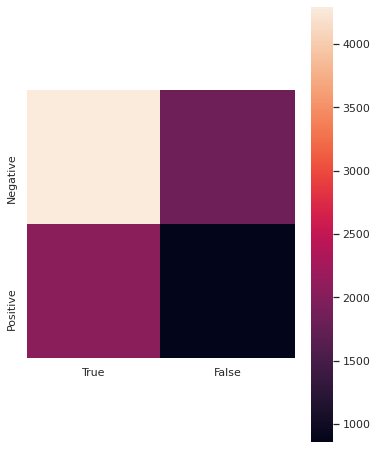

In [26]:
sns.set(rc={'figure.figsize':(6,8)})
sns.heatmap(
    data=classification_result['confusion'],
    square=True,
    xticklabels=['True', 'False'],
    yticklabels=['Negative','Positive']
)


This is the (rotated) confusion matrix of our Model. The False column should have as less values as possible, bu that is not the case. 

### Regression

The second approach is to see the satisfaction as a range.

In [27]:
def df_to_float_labels(df):
    '''
     Convert a dataframe with the columns to a float form for a regression model.
     
     :param df: (pd.DataFrame) The DataFrame that have the data to be converted to floating labels.
     :returns: (list[int]) -2 to 2, inclusive, in 1 steps represantation of the column.
     
     Example:
     >>> df_to_float_labels(  \
        pd.DataFrame( \
            [  \
                {'Very satisfied': 1},  \
                {'Slightly satisfied': 1},  \
                {'Neither satisfied nor dissatisfied': 1},  \
                {'Slightly dissatisfied': 1},  \
                {'Very dissatisfied': 1} \
            ]  \
        )  \
    )
    
    [{'label': 2}, {'label': 1}, {'label': 0}, {'label': -1}, {'label': -2}]
    '''
    
    records = []
    for index, row in df.iterrows():
        if row['Very satisfied'] == 1:
            records.append({"label": 2})
        elif row['Slightly satisfied'] == 1:
            records.append({"label": 1})
        elif row['Neither satisfied nor dissatisfied'] == 1:
            records.append({"label": 0})
        elif row['Slightly dissatisfied'] == 1:
            records.append({"label": -1})
        else: # Very dissatisfied
            records.append({"label": -2})
        
    return records

 Each Level of satisfaction will get mapped to a float values from -2 upto +2 (inclusive).

In [28]:
def fit_regression(X, y):
    '''
    Train a LinearRegression Model for a regression
    
    :param X: (pd.DataFrame) The DataFrame with the features
    :param y: (pd.DataFrame) The DataFrame with the label
    :returns: (dict) r2_score
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    classifier = LinearRegression()
    classifier.fit(X_train, y_train)
    y_pred_test = classifier.predict(X_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    y_pred_train = classifier.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)
    return {'r2_score_test': r2_test, 'r2_score_train': r2_train}


We will be fiting a simple linear regression model here, using the test-train ration of 0.2 and 0.8. 

In [29]:
float_y = pd.DataFrame(df_to_float_labels(job_satisfaction_df))

In [30]:
regression_result = fit_regression(X, float_y)

## Section 5: Evaluation
### Question 1: What is the general job satisfaction, more positive or more negative?

This can be answered by suming up the amount of each reponse in the `JobSat` column. I will be using here the "exploded" form I used for training the models 

In [31]:
def df_positive_columns(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Return a dataframe with the number of positive examples (1"s) for each column

    :param df: (pd.DataFrame)  The DataFrame to analyse 
    :returns: (pd.DataFrame) The number of positives per column
    
    Example:
    >>> df_positive_columns(pd.DataFrame([{'a': 0, 'b': 1}, {'a': 1, 'b': 0}]))
    pd.DataFrame([{'a': 1, 'b': 1}])
    '''
    
    result = {}
    cols = df.columns
    for index, row in df.iterrows():
        for c in cols:
            if c in result:
                result[c] = result[c] + row[c]
            else:
                result[c] = row[c]
    
    return pd.DataFrame([result])

In [32]:
job_salutation_count_df = df_positive_columns(job_satisfaction_df)
job_salutation_count_df.iloc[0].to_dict()

{'Slightly satisfied': 13930.0,
 'Very dissatisfied': 3746.0,
 'Slightly dissatisfied': 7124.0,
 'Very satisfied': 14611.0,
 'Neither satisfied nor dissatisfied': 5783.0}

`Slightly satisfied` have a count of *13930* and `Very satisfied` have a count of *14611*, having a total of **28541**.

I will ignore the `Neither satisfied nor dissatisfied` as we don't know if its positive or negative.

`Slightly dissatisfied` have a count of *7124* and `Very dissatisfied` have a count of *3746*, having a total of **10870**.

The majority of anwers given are more positive even when we would consider the option `Neither satisfied nor dissatisfied` as negative.

### Question 2: Is the job satisfaction correlated with some programming language, framework or platform?

#### Analyse platform

In [33]:
analyse_satisfaction_platform_df = pd.concat([job_satisfaction_df, platform_features_df],axis=1, join='inner')

for this analysis I merged constructed dataframe from job_salutation and platform together

#### Visualisation platform

<AxesSubplot:>

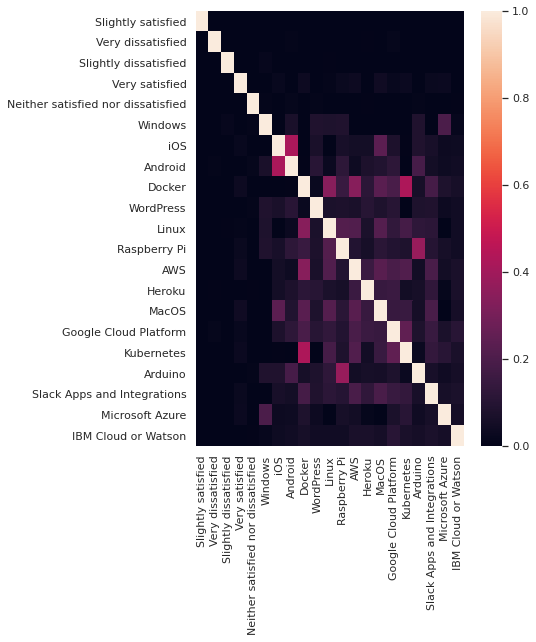

In [34]:
sns.heatmap(analyse_satisfaction_platform_df.corr(), vmin=0, vmax=1)

Following platform indicate a positive relation:

* Docker
* Raspberry Pi
* MacOS
* Kubernetes
* Slack
* Microsoft Azure

#### Analyse misc tech

In [35]:
analyse_satisfaction_platform_df = pd.concat([job_satisfaction_df, misc_tech_features_df],axis=1, join='inner')

#### Visualisation misc tech

<AxesSubplot:>

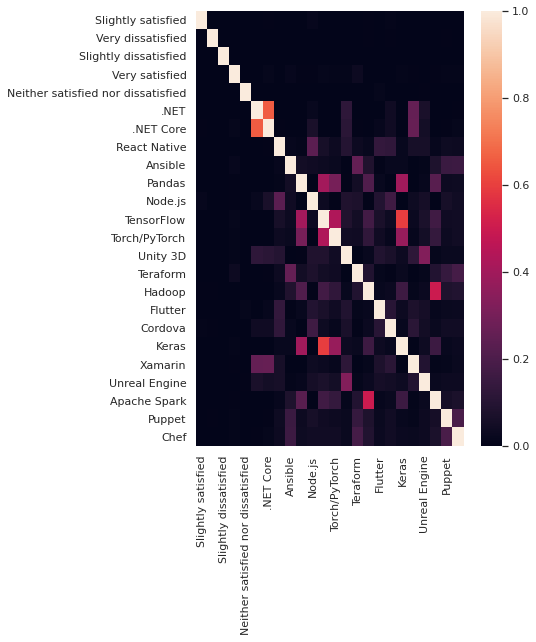

In [36]:
sns.heatmap(analyse_satisfaction_platform_df.corr(), vmin=0, vmax=1)

Only the Technology **Terraform** have a bit of a positive influence. The other have non or only so small that its barly visible in the heatmap.

#### Analyse Language

In [37]:
analyse_satisfaction_language_df = pd.concat([job_satisfaction_df, language_features_df],axis=1, join='inner')

<AxesSubplot:>

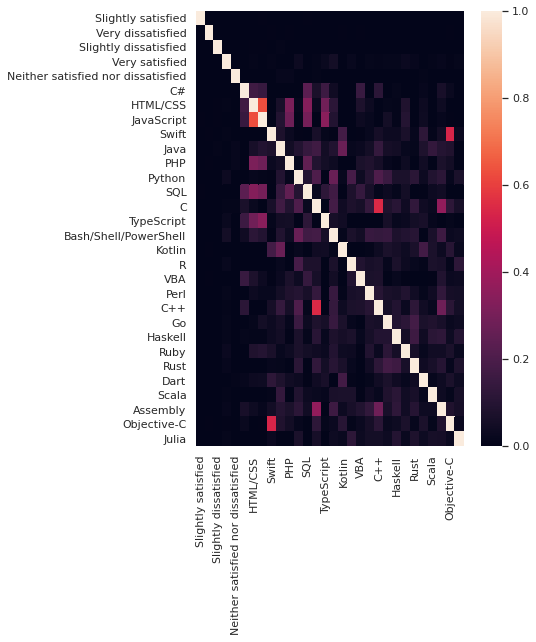

In [38]:
sns.heatmap(analyse_satisfaction_language_df.corr(), vmin=0, vmax=1)

Happy to know: **Python**, **Typescript** and **Bash/Shell/Powershell** show a positive correlation with the job salutation.

But the boxes are only a little bit brigter than the surrounding ones, sometimes you can't event see them directly.

### Question 3: Are we able to predict a job satisfaction based on this data?

In [39]:
classification_result['r2_score_train']

0.7115295113914506

From the first look, the r2 on the train data looks promising, but...

In [40]:
classification_result['r2_score_test']

-0.969936906341829

On the Test Set, we have a r2 score of *-0,96* - given that the general range is from minus infinity to 0 for a "bad" model and 1 for a perfect model, this model don't perform on the data available.

In [41]:
regression_result['r2_score_train']

0.008266392789718635

In [42]:
regression_result['r2_score_test']

0.006006631861843692

Sad for the second modelling approach, we have both on train and on the test set very low scores. They are better than using classification, but far away from a good model.

We are **not** able to predict the job satisfaction based on the analysed data.

# Header Image

<AxesSubplot:>

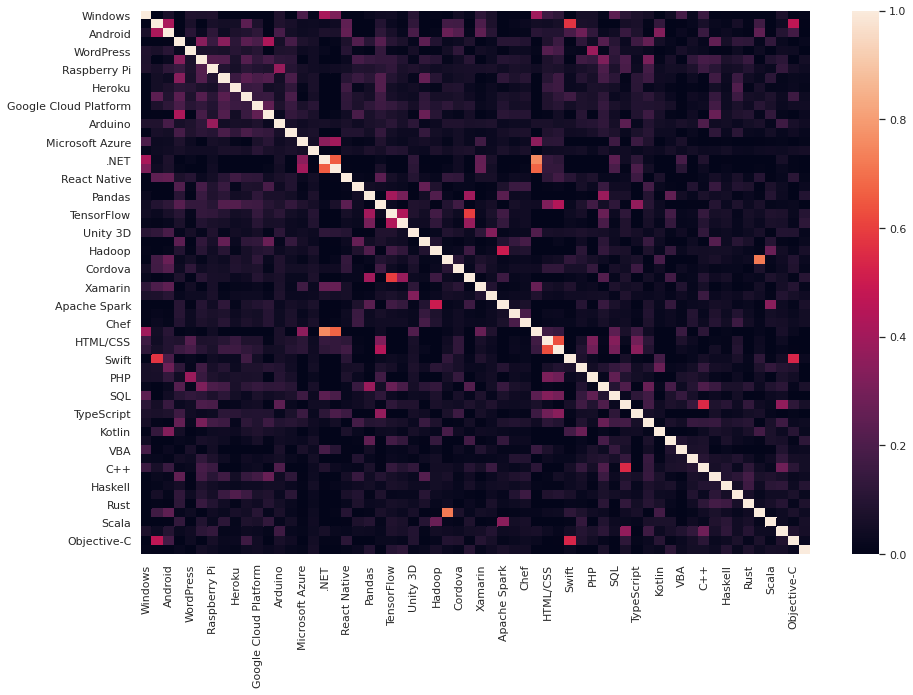

In [43]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(X.corr(), vmin=0, vmax=1)